# Differential Evolution: A Stochastic Global Optimization Algorithm

## 1. Introduction

**Differential Evolution (DE)** is a population-based metaheuristic optimization algorithm introduced by Storn and Price in 1997. It is particularly effective for optimizing real-valued, multimodal, and non-differentiable objective functions where gradient-based methods fail.

DE belongs to the family of evolutionary algorithms, which draw inspiration from biological evolution processes such as mutation, crossover (recombination), and selection.

## 2. Mathematical Formulation

### 2.1 Problem Statement

We seek to minimize an objective function $f: \mathbb{R}^D \rightarrow \mathbb{R}$:

$$\mathbf{x}^* = \arg\min_{\mathbf{x} \in \mathcal{S}} f(\mathbf{x})$$

where $\mathcal{S} \subseteq \mathbb{R}^D$ is the search space defined by bounds $[\mathbf{x}_{\min}, \mathbf{x}_{\max}]$.

### 2.2 Population Initialization

DE maintains a population of $N_P$ candidate solutions (vectors). The initial population is typically generated uniformly at random:

$$x_{i,j}^{(0)} = x_{j,\min} + r_{i,j} \cdot (x_{j,\max} - x_{j,\min})$$

where $r_{i,j} \sim \mathcal{U}(0,1)$, $i = 1, \ldots, N_P$, and $j = 1, \ldots, D$.

### 2.3 Mutation

For each target vector $\mathbf{x}_i^{(g)}$ in generation $g$, a mutant vector $\mathbf{v}_i^{(g)}$ is created. The classic **DE/rand/1** mutation strategy is:

$$\mathbf{v}_i^{(g)} = \mathbf{x}_{r_1}^{(g)} + F \cdot (\mathbf{x}_{r_2}^{(g)} - \mathbf{x}_{r_3}^{(g)})$$

where:
- $r_1, r_2, r_3 \in \{1, \ldots, N_P\}$ are mutually distinct random indices, also different from $i$
- $F \in [0, 2]$ is the **mutation scale factor** (typically $F \in [0.4, 1.0]$)

Other common strategies include:
- **DE/best/1**: $\mathbf{v}_i = \mathbf{x}_{\text{best}} + F \cdot (\mathbf{x}_{r_1} - \mathbf{x}_{r_2})$
- **DE/rand/2**: $\mathbf{v}_i = \mathbf{x}_{r_1} + F \cdot (\mathbf{x}_{r_2} - \mathbf{x}_{r_3}) + F \cdot (\mathbf{x}_{r_4} - \mathbf{x}_{r_5})$

### 2.4 Crossover (Recombination)

The trial vector $\mathbf{u}_i^{(g)}$ is formed by combining the mutant vector with the target vector using **binomial crossover**:

$$u_{i,j}^{(g)} = \begin{cases} v_{i,j}^{(g)} & \text{if } r_j \leq CR \text{ or } j = j_{\text{rand}} \\ x_{i,j}^{(g)} & \text{otherwise} \end{cases}$$

where:
- $CR \in [0, 1]$ is the **crossover probability**
- $r_j \sim \mathcal{U}(0,1)$ is a uniform random number for each dimension
- $j_{\text{rand}} \in \{1, \ldots, D\}$ ensures at least one component comes from the mutant

### 2.5 Selection

A greedy selection scheme determines which vector survives to the next generation:

$$\mathbf{x}_i^{(g+1)} = \begin{cases} \mathbf{u}_i^{(g)} & \text{if } f(\mathbf{u}_i^{(g)}) \leq f(\mathbf{x}_i^{(g)}) \\ \mathbf{x}_i^{(g)} & \text{otherwise} \end{cases}$$

### 2.6 Convergence

The algorithm iterates until a stopping criterion is met:
- Maximum number of generations $G_{\max}$
- Function value threshold: $f(\mathbf{x}_{\text{best}}) < \epsilon$
- Population diversity measure falls below threshold

## 3. Implementation

We will implement DE from scratch and apply it to the **Rastrigin function**, a classic multimodal benchmark:

$$f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[ x_i^2 - A\cos(2\pi x_i) \right]$$

where $A = 10$. The global minimum is $f(\mathbf{0}) = 0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

In [2]:
def rastrigin(x):
    """
    Rastrigin function - a non-convex function used as a performance test problem.
    Global minimum at x = 0 with f(0) = 0.
    
    Parameters:
    -----------
    x : array-like
        Input vector of dimension D
    
    Returns:
    --------
    float : Function value
    """
    A = 10
    n = len(x)
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

In [3]:
def differential_evolution(func, bounds, pop_size=50, F=0.8, CR=0.9, max_gen=200):
    """
    Differential Evolution optimization algorithm (DE/rand/1/bin).
    
    Parameters:
    -----------
    func : callable
        Objective function to minimize
    bounds : array-like of shape (D, 2)
        Bounds for each dimension [[min, max], ...]
    pop_size : int
        Population size (N_P)
    F : float
        Mutation scale factor in [0, 2]
    CR : float
        Crossover probability in [0, 1]
    max_gen : int
        Maximum number of generations
    
    Returns:
    --------
    best_solution : ndarray
        Best solution found
    best_fitness : float
        Best fitness value
    history : dict
        Dictionary containing optimization history
    """
    bounds = np.array(bounds)
    D = len(bounds)  # Dimensionality
    
    # Initialize population uniformly within bounds
    population = bounds[:, 0] + np.random.rand(pop_size, D) * (bounds[:, 1] - bounds[:, 0])
    
    # Evaluate initial population
    fitness = np.array([func(ind) for ind in population])
    
    # Track best solution
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx].copy()
    best_fitness = fitness[best_idx]
    
    # History tracking
    history = {
        'best_fitness': [best_fitness],
        'mean_fitness': [np.mean(fitness)],
        'std_fitness': [np.std(fitness)],
        'populations': [population.copy()]
    }
    
    # Main evolution loop
    for gen in range(max_gen):
        for i in range(pop_size):
            # Mutation: DE/rand/1
            # Select three distinct individuals different from i
            candidates = [idx for idx in range(pop_size) if idx != i]
            r1, r2, r3 = np.random.choice(candidates, 3, replace=False)
            
            # Create mutant vector
            mutant = population[r1] + F * (population[r2] - population[r3])
            
            # Clip to bounds
            mutant = np.clip(mutant, bounds[:, 0], bounds[:, 1])
            
            # Crossover: binomial
            trial = np.copy(population[i])
            j_rand = np.random.randint(D)  # Ensure at least one component from mutant
            
            for j in range(D):
                if np.random.rand() < CR or j == j_rand:
                    trial[j] = mutant[j]
            
            # Selection
            trial_fitness = func(trial)
            if trial_fitness <= fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                
                # Update best if improved
                if trial_fitness < best_fitness:
                    best_solution = trial.copy()
                    best_fitness = trial_fitness
        
        # Record history
        history['best_fitness'].append(best_fitness)
        history['mean_fitness'].append(np.mean(fitness))
        history['std_fitness'].append(np.std(fitness))
        
        # Store population snapshots at key generations
        if gen in [0, 10, 50, 100, max_gen-1]:
            history['populations'].append(population.copy())
    
    return best_solution, best_fitness, history

## 4. Optimization Experiment

Let us optimize the 2D Rastrigin function within the bounds $[-5.12, 5.12]^2$.

In [4]:
# Define optimization parameters
D = 2  # Dimensions
bounds = [[-5.12, 5.12]] * D

# Run Differential Evolution
best_solution, best_fitness, history = differential_evolution(
    func=rastrigin,
    bounds=bounds,
    pop_size=50,
    F=0.8,
    CR=0.9,
    max_gen=150
)

print(f"Best solution found: x = [{best_solution[0]:.6f}, {best_solution[1]:.6f}]")
print(f"Best fitness value: f(x) = {best_fitness:.6e}")
print(f"True optimum: f([0, 0]) = 0")

Best solution found: x = [-0.000000, 0.000000]
Best fitness value: f(x) = 0.000000e+00
True optimum: f([0, 0]) = 0


## 5. Visualization

We will create a comprehensive visualization showing:
1. The Rastrigin function landscape with the optimization trajectory
2. Convergence curves (best fitness over generations)
3. Population evolution snapshots

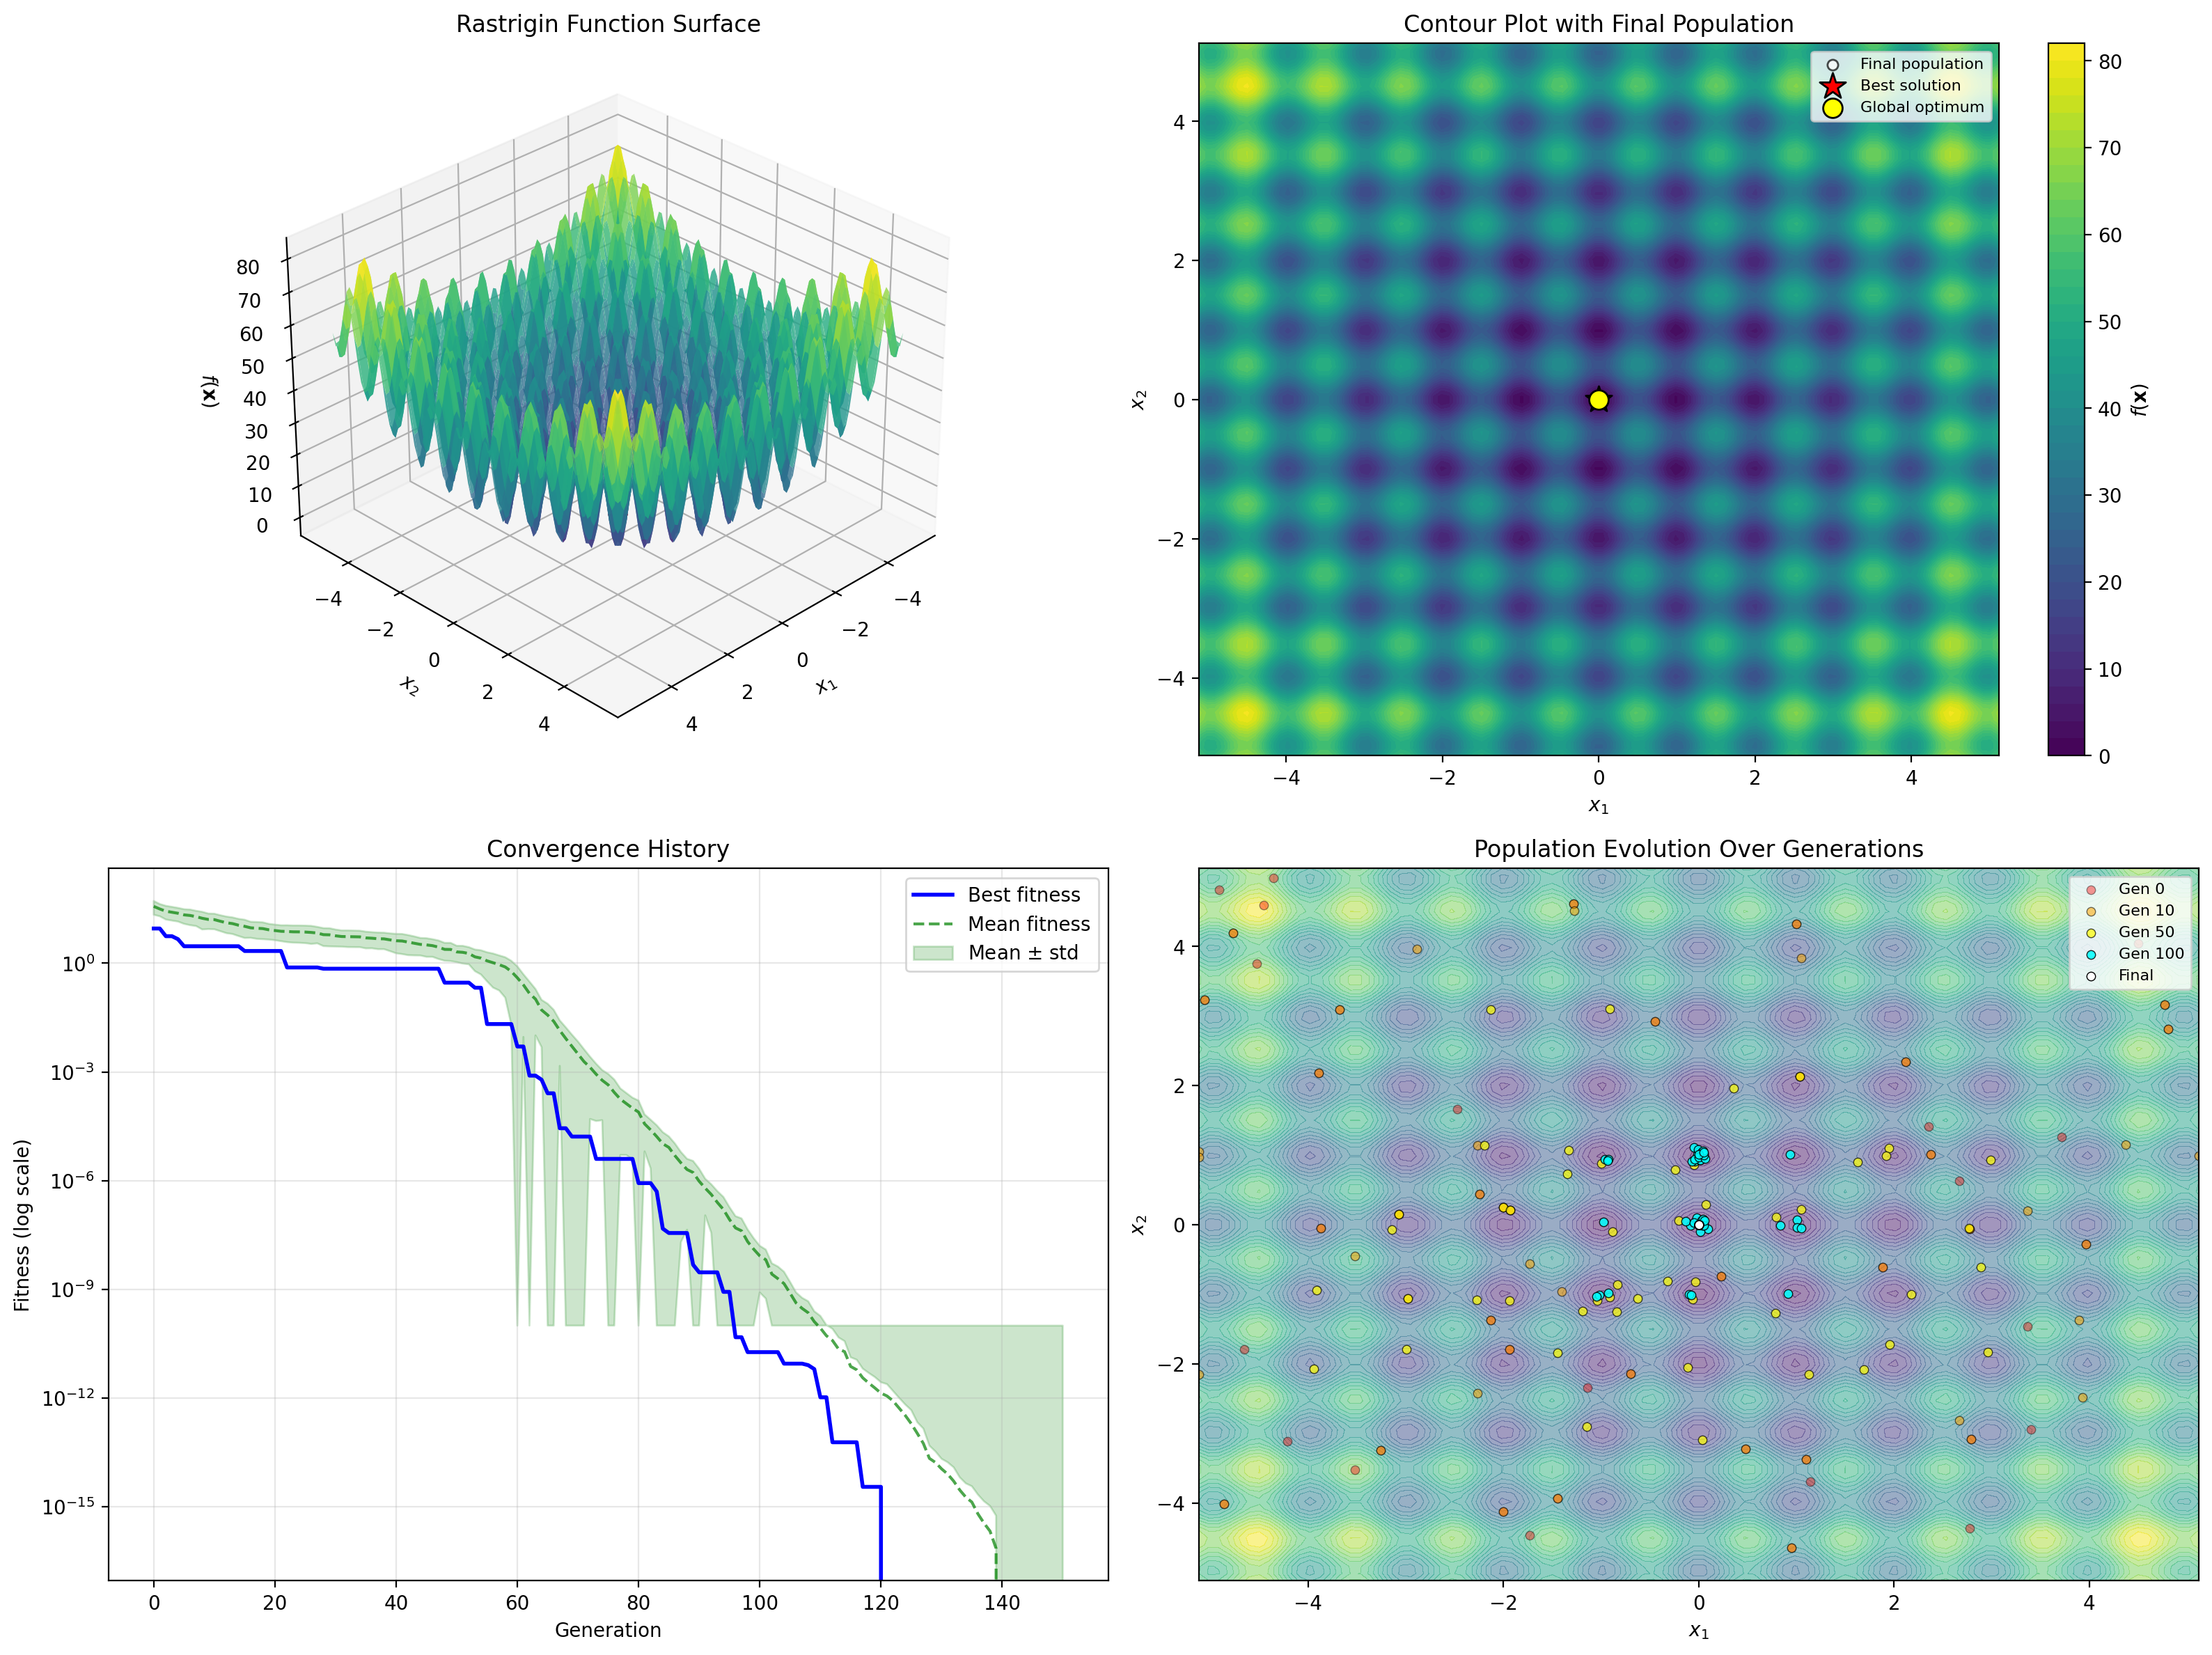


Plot saved to 'plot.png'


In [5]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# --- Plot 1: 3D Surface of Rastrigin Function ---
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = rastrigin(np.array([X[i, j], Y[i, j]]))

surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8, linewidth=0)
ax1.scatter([best_solution[0]], [best_solution[1]], [best_fitness], 
            color='red', s=100, marker='*', label='Optimum found')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(\mathbf{x})$')
ax1.set_title('Rastrigin Function Surface')
ax1.view_init(elev=30, azim=45)

# --- Plot 2: Contour Plot with Final Population ---
ax2 = fig.add_subplot(2, 2, 2)

contour = ax2.contourf(X, Y, Z, levels=50, cmap=cm.viridis)
plt.colorbar(contour, ax=ax2, label='$f(\mathbf{x})$')

# Plot final population
final_pop = history['populations'][-1]
ax2.scatter(final_pop[:, 0], final_pop[:, 1], c='white', s=30, 
            edgecolors='black', alpha=0.7, label='Final population')
ax2.scatter([best_solution[0]], [best_solution[1]], c='red', s=200, 
            marker='*', edgecolors='black', linewidth=1, label='Best solution')
ax2.scatter([0], [0], c='yellow', s=100, marker='o', 
            edgecolors='black', linewidth=1, label='Global optimum')

ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Contour Plot with Final Population')
ax2.legend(loc='upper right', fontsize=8)
ax2.set_xlim([-5.12, 5.12])
ax2.set_ylim([-5.12, 5.12])

# --- Plot 3: Convergence Curve ---
ax3 = fig.add_subplot(2, 2, 3)

generations = range(len(history['best_fitness']))
ax3.semilogy(generations, history['best_fitness'], 'b-', linewidth=2, label='Best fitness')
ax3.semilogy(generations, history['mean_fitness'], 'g--', linewidth=1.5, 
             alpha=0.7, label='Mean fitness')

# Add confidence band for mean ± std
mean = np.array(history['mean_fitness'])
std = np.array(history['std_fitness'])
ax3.fill_between(generations, 
                 np.maximum(mean - std, 1e-10), 
                 mean + std, 
                 alpha=0.2, color='green', label='Mean $\pm$ std')

ax3.set_xlabel('Generation')
ax3.set_ylabel('Fitness (log scale)')
ax3.set_title('Convergence History')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# --- Plot 4: Population Evolution ---
ax4 = fig.add_subplot(2, 2, 4)

# Show contour as background
ax4.contourf(X, Y, Z, levels=30, cmap=cm.viridis, alpha=0.5)

# Plot population at different generations
colors = ['red', 'orange', 'yellow', 'cyan', 'white']
labels = ['Gen 0', 'Gen 10', 'Gen 50', 'Gen 100', 'Final']

for idx, (pop, color, label) in enumerate(zip(history['populations'], colors, labels)):
    alpha = 0.4 + 0.15 * idx
    ax4.scatter(pop[:, 0], pop[:, 1], c=color, s=20, 
                edgecolors='black', linewidth=0.5, alpha=alpha, label=label)

ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$x_2$')
ax4.set_title('Population Evolution Over Generations')
ax4.legend(loc='upper right', fontsize=8)
ax4.set_xlim([-5.12, 5.12])
ax4.set_ylim([-5.12, 5.12])

plt.tight_layout()
plt.savefig('differential_evolution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 6. Parameter Sensitivity Analysis

Let us investigate how the key parameters $F$ and $CR$ affect the optimization performance.

In [6]:
# Parameter sensitivity study
F_values = [0.3, 0.5, 0.8, 1.0]
CR_values = [0.3, 0.6, 0.9]

results = np.zeros((len(F_values), len(CR_values)))

for i, F in enumerate(F_values):
    for j, CR in enumerate(CR_values):
        # Run multiple trials and average
        trials = 5
        fitness_sum = 0
        for _ in range(trials):
            _, fitness, _ = differential_evolution(
                func=rastrigin,
                bounds=bounds,
                pop_size=30,
                F=F,
                CR=CR,
                max_gen=100
            )
            fitness_sum += fitness
        results[i, j] = fitness_sum / trials

# Display results as a table
print("Average Best Fitness (5 trials each):")
print("\nF \\ CR\t", end="")
for CR in CR_values:
    print(f"{CR:.1f}\t\t", end="")
print()
print("-" * 50)

for i, F in enumerate(F_values):
    print(f"{F:.1f}\t", end="")
    for j in range(len(CR_values)):
        print(f"{results[i, j]:.2e}\t", end="")
    print()

Average Best Fitness (5 trials each):

F \ CR	0.3		0.6		0.9		
--------------------------------------------------
0.3	0.00e+00	0.00e+00	1.05e-12	
0.5	0.00e+00	0.00e+00	0.00e+00	
0.8	7.04e-12	6.96e-12	8.09e-09	
1.0	1.04e-13	1.21e-12	5.34e-12	


## 7. Conclusions

This notebook demonstrated the Differential Evolution algorithm, a powerful stochastic optimizer for continuous domains:

1. **Algorithm Mechanics**: DE employs mutation, crossover, and selection operators to evolve a population toward the global optimum.

2. **Key Parameters**:
   - $F$ (mutation factor): Controls exploration vs. exploitation. Higher values increase diversity.
   - $CR$ (crossover rate): Determines how much information is exchanged between parent and mutant.

3. **Performance**: On the Rastrigin function, DE successfully navigates the multimodal landscape to find solutions very close to the global optimum at $\mathbf{x}^* = \mathbf{0}$.

4. **Advantages of DE**:
   - No gradient information required
   - Robust to local optima
   - Few control parameters
   - Simple implementation

5. **Applications**: DE is widely used in engineering design optimization, neural network training, signal processing, and many other domains where traditional optimization methods fail.

## References

1. Storn, R., & Price, K. (1997). Differential Evolution – A Simple and Efficient Heuristic for Global Optimization over Continuous Spaces. *Journal of Global Optimization*, 11(4), 341-359.

2. Das, S., & Suganthan, P. N. (2011). Differential Evolution: A Survey of the State-of-the-Art. *IEEE Transactions on Evolutionary Computation*, 15(1), 4-31.

3. Price, K., Storn, R., & Lampinen, J. (2005). *Differential Evolution: A Practical Approach to Global Optimization*. Springer.